# Class-Based Chemical Similarities

Calculate the inter- and intra-class chemical similarities, using two different fingerprints, implemented in the RDKit:

* ECFC4, a count fingerprint with radius 2 
* ECFP6, a bit fingerprint of length 1024 with radius 3

For a comparison of fingerprints in the RDKit, see e.g.:  
Riniker, S.; Landrum, G. A. Open-Source Platform to Benchmark Fingerprints for Ligand-Based Virtual Screening. J Cheminform 2013, 5 (1), 26. https://doi.org/10.1186/1758-2946-5-26.


For reference, a random set of 100 compounds from the processed DrugBank data set is used.

In [1]:
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass  # to silence scikit-learn warnings

import warnings
warnings.filterwarnings('ignore')
warnings.warn = warn

# Stdlib Imports
from pathlib import Path
import sys
import functools

# Global package Imports
import pandas as pd
import numpy as np
from scipy.stats import median_absolute_deviation as mad

from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors as Desc
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import IPythonConsole

from Contrib.NP_Score import npscorer

import matplotlib.pyplot as plt
import seaborn as sns


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Project-local Imports
PROJECT_DIR = list(Path("..").absolute().parents)[1]
sys.path.append(str(PROJECT_DIR))
import plt_style
import utils as u
from utils import lp

In [3]:
# ecfc4 (default)
@functools.lru_cache
def fp_ecfc4_from_smiles(smi):
    mol = Chem.MolFromSmiles(smi)
    fp = Chem.GetMorganFingerprint(mol, 2)
    return fp

# ecfp6
@functools.lru_cache
def fp_ecfp6_from_smiles(smi):
    mol = Chem.MolFromSmiles(smi)
    fp = Chem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
    return fp

def class_sim(list1, list2=None, fp="ecfc4"):
    if fp.lower() == "ecfc4":
        print("  using ECFC4 fingerprint.")
        fp_from_smiles = fp_ecfc4_from_smiles
    else:
        print("  using ECFP6 fingerprint.")
        fp_from_smiles = fp_ecfp6_from_smiles
        
    result = []
    if list2 is None: # comparison within one class
        last_index = len(list1) - 1
    else:
        last_index = len(list1)
    for idx1, smi1 in enumerate(list1[:last_index]):
        if list2 is None:
            for smi2 in list1[idx1+1:]:
                if smi1 == smi2: continue
                fp1 = fp_from_smiles(smi1)
                fp2 = fp_from_smiles(smi2)
                result.append(DataStructs.TanimotoSimilarity(fp1, fp2))
        else:
            for smi2 in list2:
                if smi1 == smi2: continue
                fp1 = fp_from_smiles(smi1)
                fp2 = fp_from_smiles(smi2)
                result.append(DataStructs.TanimotoSimilarity(fp1, fp2))
    return result

In [4]:
fingerprint = "ecfc4"  # ecfc4 (default), ecfp6

input_dir = "../Input Data/"
tmp_dir = "../tmp"
!ls "$input_dir"

chembl_26_natprot_ids_only.tsv
chembl_np_std_np_scout_values_only.tsv
drugbank_sample_100.tsv
drugbank_std_np_scout_values_only.tsv
drugbank_std_subset_np_scout_values_only.tsv
internal_cpds_mc.tsv
internal_cpds_old_cpd_class.tsv
internal_cpds_std_np_scout.tsv
internal_cpds_std_np_scout_values_only.tsv
internal_cpds_std.tsv
internal_cpds.tsv
README.md


## Load Compounds

In [5]:
cpds = pd.read_csv(f"{tmp_dir}/internal_cpds_mc.tsv", sep="\t")
lp(cpds)

cpds.head()

Shape                                             :        244 /    3  [ Compound_Id, CpdClass, Smiles ]  


,Compound_Id,CpdClass,Smiles
0,408580,QN-C-S,COc1ccc2nccc(C(O)C3CC4CCN3CC43CC(=O)c4ccccc4O3...
1,408614,QN-C-S,COc1ccc2nccc(C(O)C3CC4CCN3CC43CC(=O)c4cc(Br)cc...
2,409679,QN-C-S,COc1ccc2nccc(C(O)C3CC4CCN3CC43CC(=O)c4cc(Cl)cc...
3,408605,QN-C-S,COc1ccc2nccc(C(O)C3CC4CCN3CC43CC(=O)c4cc(F)ccc...
4,408610,QN-C-S,COc1ccc2c(c1)OC1(CC2=O)CN2CCC1CC2C(O)c1ccnc2cc...


## Add Reference Data

A random subgroup of 100 compounds from the processed DrugBank data set is added for reference.

In [6]:
refs = pd.read_csv(f"{tmp_dir}/drugbank_std.tsv", sep="\t")
refs = refs.sample(n=100, random_state=0xc0ffee)
refs[["DATABASE_ID"]].to_csv(f"{input_dir}/drugbank_sample_100.tsv", sep="\t", index=False)

refs = refs.reset_index(drop=True).reset_index()
refs = refs.rename(columns={"index": "Compound_Id"})
refs = refs.drop("DATABASE_ID", axis=1)
refs["CpdClass"] = "_Ref"
lp(refs)

Shape                                             :        100 /    3  [ Compound_Id, Smiles, CpdClass ]  


In [7]:
cpds = pd.concat([cpds, refs])
lp(cpds)

Shape                                             :        344 /    3  [ Compound_Id, CpdClass, Smiles ]  


## Intra- / Inter-Class Similarity

In [8]:
cpd_classes = sorted(list(cpds["CpdClass"].unique()))
cpd_classes

['GF-I-1',
 'GF-I-2',
 'GF-THPI',
 'QD-C-R',
 'QD-C-S',
 'QD-I',
 'QN-C-R',
 'QN-C-S',
 'QN-I',
 'SM-C-R',
 'SM-C-S',
 'SM-I-closed',
 'SM-I-opened',
 '_Ref']

In [9]:
series_cpd_class1 = []
series_cpd_class2 = []
series_sim = []
for idx1, cpd_class1 in enumerate(cpd_classes):
    for cpd_class2 in cpd_classes[idx1:]:
        list1 = list(cpds[cpds["CpdClass"] == cpd_class1]["Smiles"].values)
        list2 = list(cpds[cpds["CpdClass"] == cpd_class2]["Smiles"].values)
        sims = class_sim(list1, list2, fp=fingerprint)
        series_cpd_class1.extend([cpd_class1] * len(sims))
        series_cpd_class2.extend([cpd_class2] * len(sims))
        series_sim.extend(sims)

  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
  using ECFC4 fingerprint.
 

In [10]:
df_sim_inter = pd.DataFrame({"CpdClass1": series_cpd_class1, "CpdClass2": series_cpd_class2, "ChemSim": series_sim})
df_sim_inter.to_csv(f"results/chemsim_inter_{fingerprint}.tsv", sep="\t", index=False)
lp(df_sim_inter)

Shape                                             :      66226 /    3  [ CpdClass1, CpdClass2, ChemSim ]  


In [11]:
df_sim_inter.head()

,CpdClass1,CpdClass2,ChemSim
0,GF-I-1,GF-I-1,0.797753
1,GF-I-1,GF-I-1,0.755319
2,GF-I-1,GF-I-1,0.771739
3,GF-I-1,GF-I-1,0.737864
4,GF-I-1,GF-I-1,0.731959


In [12]:
df_sim_inter_grp = df_sim_inter.groupby(by=["CpdClass1", "CpdClass2"]).agg([np.median, mad]).reset_index()
df_sim_inter_grp.columns = df_sim_inter_grp.columns.map('_'.join)
df_sim_inter_grp = df_sim_inter_grp.rename(columns={"CpdClass1_": "CpdClass1", "CpdClass2_": "CpdClass2"})

df_sim_inter_grp.to_csv(f"results/chemsim_inter_{fingerprint}_agg.tsv", sep="\t", index=False)
df_sim_inter_grp.head()

,CpdClass1,CpdClass2,ChemSim_median,ChemSim_median_absolute_deviation
0,GF-I-1,GF-I-1,0.675676,0.079306
1,GF-I-1,GF-I-2,0.532710,0.054942
2,GF-I-1,GF-THPI,0.491667,0.035471
3,GF-I-1,QD-C-R,0.218906,0.035991
4,GF-I-1,QD-C-S,0.207792,0.037661


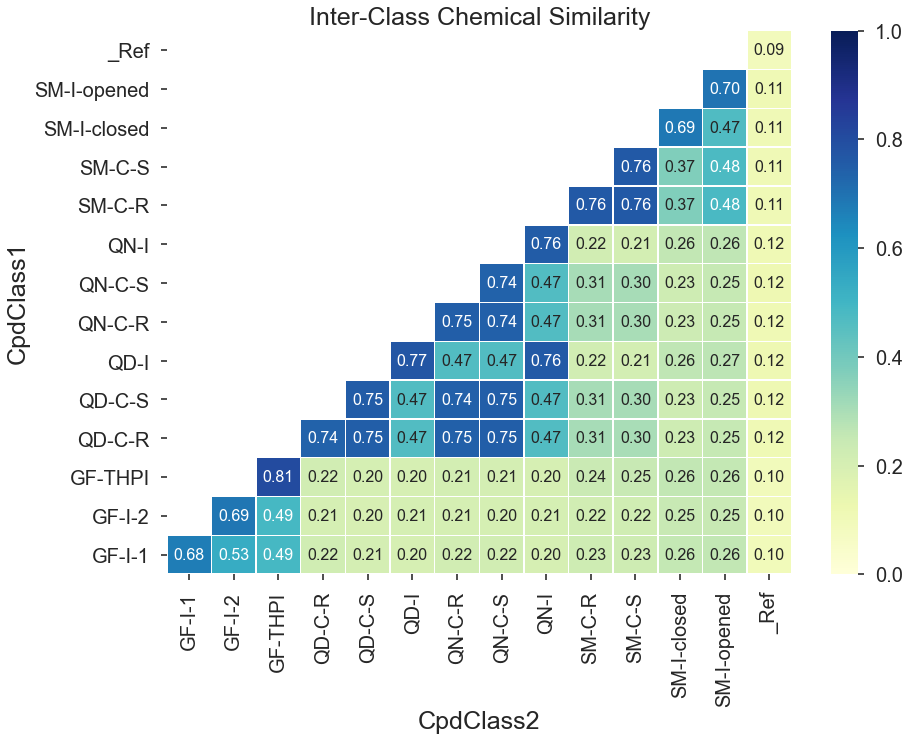

In [13]:
tmp = df_sim_inter_grp.copy()
# tmp["ChemSim_median"] = tmp["ChemSim_median"] * 100
tmp = tmp.pivot("CpdClass1", "CpdClass2", "ChemSim_median")
f, ax = plt.subplots(figsize=(14, 10))
hm = sns.heatmap(tmp, annot=True, fmt=".2f", linewidths=.5, annot_kws={"size": 16}, cmap="YlGnBu", vmin=0.0, vmax=1.0, ax=ax);
hm.invert_yaxis()
hm.set_title("Inter-Class Chemical Similarity")
fig = hm.get_figure()
fig.savefig(f"plots/chem_sim_inter_{fingerprint}.png", bbox_inches='tight');

## Similarity Distributions
### KDE Plot

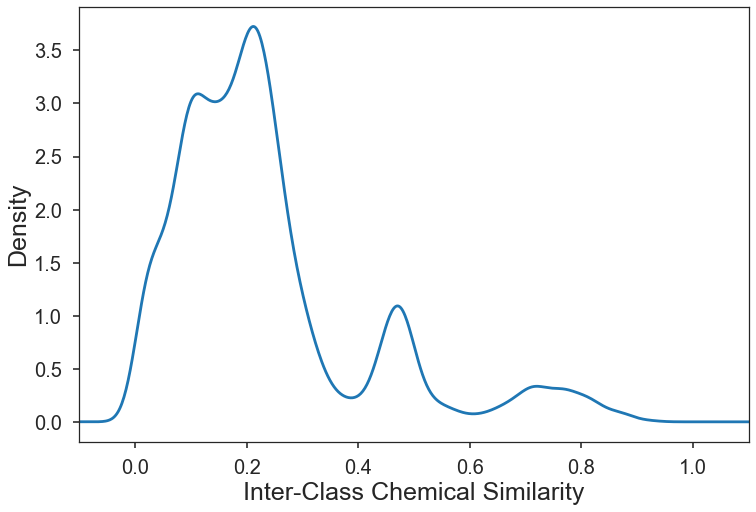

In [14]:
tmp = df_sim_inter.copy()
tmp = tmp[tmp["CpdClass1"] != tmp["CpdClass2"]]
# tmp["ChemSim"] = tmp["ChemSim"] * 100
fig, _ = plt.subplots(figsize=(12, 8))
tmp["ChemSim"].plot.density()
plt.xlim(-0.1, 1.1)
plt.xlabel("Inter-Class Chemical Similarity");
# plt.legend();
fig.savefig(f"plots/chem_sim_inter_{fingerprint}_dist.png", bbox_inches='tight');

### Box Plots

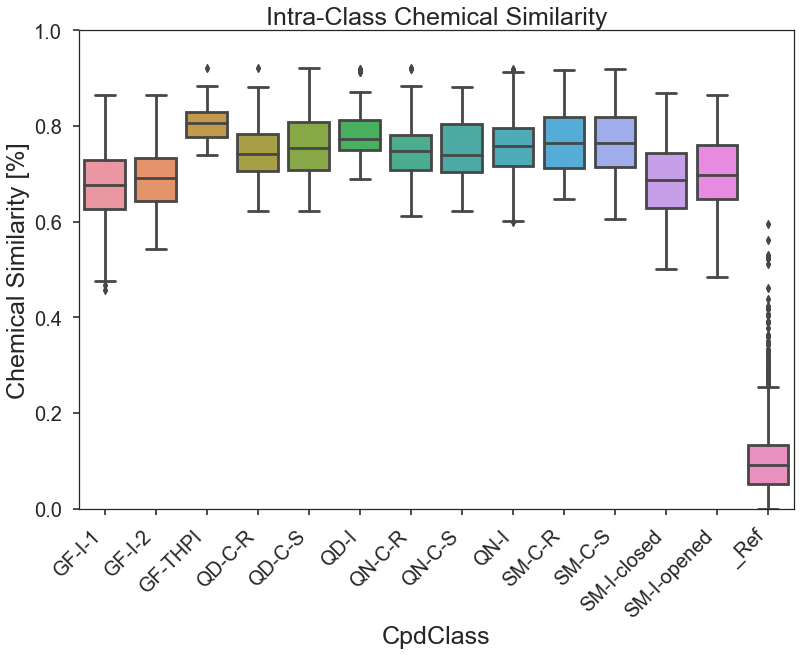

In [15]:
tmp = df_sim_inter.copy()
tmp = tmp[tmp["CpdClass1"] == tmp["CpdClass2"]]
# tmp.head()
tmp = tmp.sort_values("CpdClass1")
tmp = tmp.rename(columns={"CpdClass1": "CpdClass"})
# tmp["ChemSim"] = tmp["ChemSim"] * 100

box = sns.boxplot(x=tmp["CpdClass"], y=tmp["ChemSim"]);
box.set_xticklabels(box.get_xticklabels(), rotation=45, horizontalalignment='right')
box.set_ylim(0.0, 1.0)
box.set_title("Intra-Class Chemical Similarity")
box.set_ylabel("Chemical Similarity [%]");
#plt.legend();
fig = box.get_figure()
fig.savefig(f"plots/chem_sim_inter_{fingerprint}_box.png", bbox_inches='tight');